In [1]:
import sys
sys.path.append("/home/zhhu/workspaces/deepinv/")

In [2]:
from datetime import datetime
import deepinv as dinv
import gc
from pathlib import Path
from time import time
import math

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot, plot_curves
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity, spectral_methods, default_preprocessing, spectral_methods_wrapper, plot_error_bars
from deepinv.models.complex import to_complex_denoiser

In [3]:
url = get_image_url("SheppLogan.png")

# Time complexity

In [5]:
# img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 256]
img_sizes: list[int] = [8, 16, 32, 64, 96, 128, 160, 192, 224, 240]
print(img_sizes)
n_repeats = 100
oversampling = 1

[8, 16, 32, 64, 96, 128, 160, 192, 224, 240]


In [6]:
device = torch.device("cuda",index=0)
device

device(type='cuda', index=0)

In [7]:
torch.cuda.empty_cache()

In [6]:
# works well if not in class
foo = torch.randn((240**2, 240**2), device=device, dtype=torch.cfloat)
bar = foo

In [ ]:
# problem is the division
class Foo:
    def __init__(self):
        self.foo = torch.randn((240**2, 240**2), device=device, dtype=torch.cfloat) / np.sqrt(240**2)

Foo().foo

In [6]:
physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*240**2),
            img_shape= (1, 240, 240),
            dtype = torch.cfloat,
            device=device,
            test=True,
        )

In [7]:
physics.release_memory()

allocated memory: 0


In [ ]:
# random model

df_random_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    torch.cuda.empty_cache()
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)
    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.cfloat,
            device=device,
            test=True,
        )
        torch.cuda.synchronize()
        init_time = time()
        y = physics.forward(x_phase)
        torch.cuda.synchronize()
        df_random_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        physics.release_memory()
        torch.cuda.empty_cache()
        print("allocated memory after clearing cache", torch.cuda.memory_allocated(device)/1024**2,"MB")

In [7]:
df_random_gpu.to_csv("df_random_gpu.csv", index=False)
df_random_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.451463,0.000501,0.000638,0.00054,0.001046,0.003431,0.007872,0.016202,0.029026,0.031205
1,0.000252,0.000467,0.000466,0.000386,0.0012,0.00333,0.007773,0.016022,0.023464,0.031089
2,0.000179,0.00046,0.000462,0.000367,0.001196,0.003243,0.007803,0.016826,0.02349,0.031042
3,0.00017,0.000459,0.000453,0.000364,0.001208,0.003246,0.00778,0.016126,0.023477,0.03113
4,0.000168,0.000459,0.000451,0.000364,0.001168,0.003349,0.007809,0.015985,0.023582,0.031191
...,...,...,...,...,...,...,...,...,...,...
95,0.000164,0.000173,0.000174,0.000299,0.001241,0.003373,0.007748,0.016134,0.023584,0.031102
96,0.000164,0.000172,0.00017,0.000296,0.001233,0.0034,0.007826,0.016018,0.023588,0.030983
97,0.000164,0.000172,0.000168,0.000296,0.00123,0.003401,0.00777,0.016045,0.023482,0.031095
98,0.000165,0.000174,0.000168,0.000297,0.001246,0.003392,0.007826,0.015952,0.023474,0.031016


In [10]:
# structured model
df_structured_gpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device)
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

    torch.cuda.synchronize()
    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.cfloat,
            device=device,
        )
        init_time = time()
        torch.cuda.synchronize()
        y = physics.forward(x_phase)
        df_structured_gpu.loc[i, f"img_size_{img_size}"] = time() - init_time
        torch.cuda.synchronize()
        physics.release_memory()
        torch.cuda.synchronize()

100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


In [12]:
df_structured_gpu.to_csv("paper/data/time/df_structured_gpu.csv", index=False)
df_structured_gpu

,img_size_8,img_size_16,img_size_32,img_size_64,img_size_96,img_size_128,img_size_160,img_size_192,img_size_224,img_size_240
0,0.000622,0.0006,0.000474,0.000599,0.000604,0.000614,0.000616,0.000591,0.000397,0.000668
1,0.000585,0.000626,0.000453,0.000578,0.000588,0.000577,0.000574,0.000545,0.000395,0.000636
2,0.000584,0.000567,0.000442,0.000568,0.000572,0.00057,0.000571,0.000577,0.000364,0.000632
3,0.000579,0.000568,0.000445,0.000576,0.000567,0.000571,0.000571,0.000528,0.000362,0.000626
4,0.000577,0.000563,0.000445,0.000562,0.000567,0.000567,0.000566,0.000531,0.00036,0.000572
...,...,...,...,...,...,...,...,...,...,...
95,0.0002,0.000224,0.000229,0.00023,0.000227,0.000202,0.000216,0.000222,0.000228,0.000211
96,0.000199,0.000221,0.000228,0.000222,0.000212,0.000201,0.000217,0.000209,0.000223,0.000211
97,0.000201,0.000222,0.00025,0.000223,0.000212,0.000196,0.000218,0.000206,0.000223,0.000221
98,0.0002,0.000221,0.000222,0.000222,0.000213,0.000197,0.000217,0.000216,0.000222,0.000205


In [13]:
device = 'cpu'

In [26]:
# random model
df_random_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.RandomPhaseRetrieval(
            m = int(oversampling*torch.prod(torch.tensor(x.shape))),
            img_shape= (1, img_size, img_size),
            dtype = torch.cfloat,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_random_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

 80%|████████  | 8/10 [1:07:40<35:48, 1074.12s/it]

In [16]:
# structured model
df_structured_cpu = pd.DataFrame(
    {
        **{f"img_size_{img_size}": None for img_size in np.array(img_sizes)},
    },
    index=[0]
)

for img_size in tqdm(img_sizes):
    img_size = img_size
    x = load_url_image(url=url, img_size=img_size, grayscale=True, resize_mode="resize", device='cpu')
    x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to('cpu')

    for i in range(n_repeats):
        physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=2,
            input_shape=(1, img_size, img_size),
            output_shape=(1, int(math.sqrt(oversampling))*img_size, int(math.sqrt(oversampling))*img_size),
            dtype = torch.cfloat,
            device='cpu',
        )
        init_time = time()
        y = physics.forward(x_phase)
        df_structured_cpu.loc[i, f"img_size_{img_size}"] = time() - init_time

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


In [17]:
df_structured_cpu.to_csv("paper/data/time/df_structured_cpu.csv", index=False)
df_structured_cpu.mean(axis=0)

img_size_8      0.000192
img_size_16     0.000185
img_size_32     0.000223
img_size_64     0.000314
img_size_96     0.000435
img_size_128    0.000539
img_size_160    0.000769
img_size_192    0.002995
img_size_224    0.003131
img_size_240    0.003242
dtype: object

In [15]:
pixels = [i**2 for i in img_sizes]

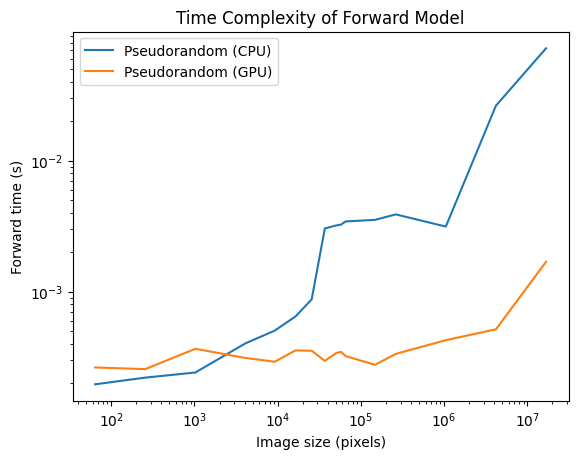

In [22]:
# plt.plot(pixels,df_random_cpu.mean(axis=0),label='Random (CPU)')
# plt.plot(pixels,df_random_gpu.mean(axis=0),label='Random (GPU)')
plt.plot(pixels,df_structured_cpu.mean(axis=0),label='structured (CPU)')
plt.plot(pixels,df_structured_gpu.mean(axis=0),label='structured (GPU)')
plt.xlabel('Image size (pixels)')
plt.ylabel('Forward time (s)')
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time Complexity of Forward Model')
plt.legend()
plt.savefig('time.svg')
plt.show()

In [127]:
# save data
df_random_cpu.to_csv('df_random_cpu.csv')
df_random_gpu.to_csv('df_random_gpu.csv')
df_structured_cpu.to_csv('df_structured_cpu.csv')
df_structured_gpu.to_csv('df_structured_gpu.csv')

In [ ]:
plot_error_bars([pixels] * 4,
                [df_random_cpu, df_random_gpu, df_structured_cpu, df_structured_gpu],
                ['Random (CPU)', 'Random (GPU)', 'structured (CPU)', 'structured (GPU)'],
                title = f'Forward time (s) vs Image size (oversampling={oversampling})',
                xlabel = 'Image size',
                xscale = 'log',
                ylabel = 'Forward time (s)',
                yscale = 'log',
                axis = 0)

# Random Model Test

In [25]:
# Set up the variable to fetch dataset and operators.
img_size = 64
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [55]:
data_fidelity = L2()
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-3, use 1e-2 for oversampling ratio 3-9
step_size = 1e-2
oversampling = 5

In [56]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=oversampling*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.cfloat,
    device=device,
)
y = physics(x_phase)

In [57]:
def random_init(y, physics):
    x = torch.randn_like(x_phase)
    z = x.detach().clone()
    return {"est": (x, z)}

In [58]:
params_algo = {"stepsize": step_size * oversampling, "g_params": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=random_init,
)

x_phase_gd_spec, metrics = model(y, physics, x_gt=x_phase, compute_metrics=True)

stepsize: 0.05


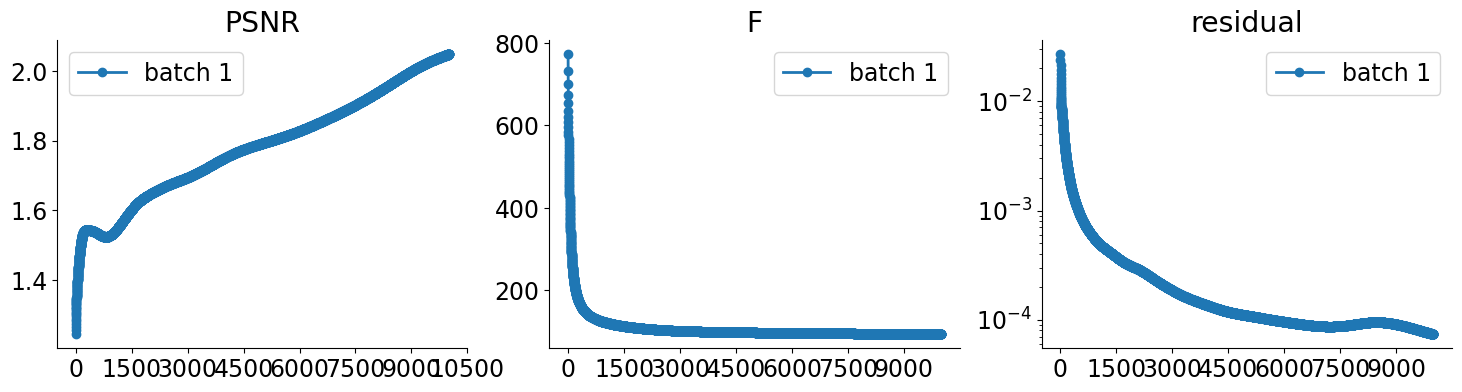

In [59]:
plot_curves(metrics)

Image 0, channel 0 does not have a global phase shift.
Cosine similarity: 0.0650


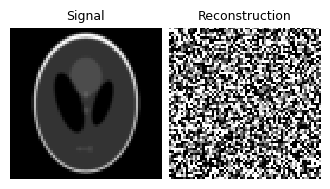

In [60]:
x_phase_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_phase_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

In [106]:
oversampling_ratios = torch.cat((torch.arange(0.1,3.1,0.1),torch.arange(3.5,9.5,0.5)))
oversampling_ratios

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000, 1.8000,
        1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000, 2.7000,
        2.8000, 2.9000, 3.0000, 3.5000, 4.0000, 4.5000, 5.0000, 5.5000, 6.0000,
        6.5000, 7.0000, 7.5000, 8.0000, 8.5000, 9.0000])

# Use PnP as regularizer

In [ ]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [ ]:
noise_level_img = 0.05

physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, img_size, img_size),
    output_shape=(1, 171, 171),
    dtype=torch.cfloat,
    device=device,
    #noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img)
)
y = physics(x_phase)

In [ ]:
n_channels = 1

denoiser = DRUNet(
    in_channels=n_channels,
    out_channels=n_channels,
    pretrained="download",  # automatically downloads the pretrained weights, set to a path to use custom weights.
    train=False,
    device=device,
) # TODO: use dncnn lipschitz constant
denoiser_complex = to_complex_denoiser(denoiser,mode="abs_angle")

In [ ]:
data_fidelity = L2()
prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
#prior = dinv.optim.prior.Zero()
max_iter = 5000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-5

In [ ]:
params_algo = {"stepsize": step_size, "g_param": 0.10}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase, compute_metrics=True)

stepsize: 1e-05


Image 0, channel 0 does not have a global phase shift.


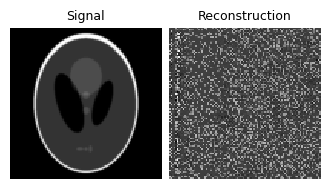

Cosine similarity: 0.1567


In [ ]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# Use shared weights

In [6]:
# Set up the variable to fetch dataset and operators.
img_size = 128
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [7]:
physics = dinv.physics.StructuredRandomPhaseRetrieval(
    n_layers=2,
    input_shape=(1, img_size, img_size),
    output_shape=(1, 202, 202),
    dtype=torch.cfloat,
    device=device,
    drop_tail=True,
)

y = physics(x_phase)

Power iteration early stopping at iteration 3933.
tensor([[[[-3.4575e-08+3.1665e-08j, -2.1420e-08+4.3539e-08j,
            2.3516e-08+4.1910e-09j,  ...,
            5.6811e-08+6.5193e-09j,  3.1549e-08-7.5903e-08j,
            5.9605e-08+2.3283e-08j],
          [ 8.9640e-08-7.5670e-09j, -5.2154e-08+1.9791e-08j,
           -5.5879e-09-4.7847e-08j,  ...,
           -1.1642e-10-9.3598e-08j, -2.7940e-09-3.9698e-08j,
           -1.7229e-08-7.1712e-08j],
          [ 9.3714e-08+7.1712e-08j,  1.5134e-08+6.4261e-08j,
            5.7975e-08-1.1642e-09j,  ...,
            1.9092e-08+4.3772e-08j,  2.2119e-08-5.6811e-08j,
           -2.5611e-08-6.9849e-09j],
          ...,
          [-2.9802e-08-1.3039e-07j, -9.1270e-08-1.4901e-08j,
           -2.6812e-08+2.9337e-08j,  ...,
           -2.2817e-08-9.9652e-08j, -2.7736e-08-2.1188e-08j,
           -1.9558e-08-8.8476e-09j],
          [-8.8010e-08-2.3283e-08j,  3.7020e-08-5.4482e-08j,
           -3.8650e-08-5.2154e-08j,  ...,
            2.8405e-08-5.192

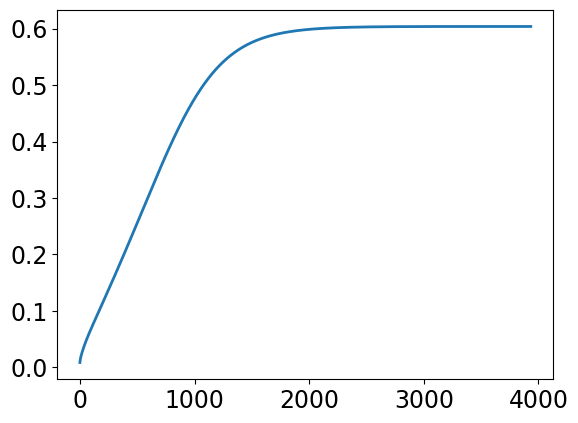

In [8]:
x_phase_1, metrics = spectral_methods(y, physics, n_iter=5000, log=True, x_true=x_phase,rtol=1e-5)
cosine_similarity(x_phase_1, x_phase)
metrics = [i.cpu().numpy() for i in metrics]
plt.plot(metrics)
plt.show()

In [51]:
physics.diagonals

[tensor([[[-0.4501-0.8930j, -0.6903-0.7235j, -0.3409+0.9401j,  ...,
            0.3860-0.9225j, -0.9152+0.4030j,  0.8253-0.5646j],
          [ 0.7835-0.6213j,  0.3299-0.9440j, -0.4560-0.8900j,  ...,
            0.3489-0.9372j,  0.7486-0.6630j, -0.7159+0.6982j],
          [-0.9056-0.4241j,  0.8376-0.5462j,  0.9636-0.2672j,  ...,
            0.2538+0.9672j, -0.0745-0.9972j, -0.9830-0.1835j],
          ...,
          [ 0.9640+0.2657j, -0.8663-0.4996j, -0.7159+0.6982j,  ...,
            0.1277+0.9918j,  0.9837-0.1796j,  0.3925-0.9198j],
          [ 0.4512+0.8924j,  0.9842-0.1771j, -0.8482-0.5297j,  ...,
           -0.8160+0.5781j,  0.5181-0.8553j,  0.9965-0.0833j],
          [ 0.6226+0.7826j,  0.8461+0.5331j,  0.8266-0.5628j,  ...,
            0.9924+0.1232j, -0.6313+0.7755j, -0.5331-0.8461j]]],
        device='cuda:0'),
 tensor([[[ 0.4369-0.8995j, -0.9699-0.2434j,  0.8604+0.5096j,  ...,
            0.1439-0.9896j, -0.0121-0.9999j,  0.8225+0.5688j],
          [-0.9448-0.3276j, -0.5258-0.85

In [52]:
assert torch.allclose((physics.B.A_adjoint(physics.B(x_phase))),x_phase)

In [53]:
data_fidelity = L2()
#prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
prior = dinv.optim.prior.Zero()
max_iter = 30000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 4e-3*3

In [54]:
def spectral_methods_wrapper(y, physics, n_iter=5000, **kwargs):
    x = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    z = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    return {"est": (x, z)}

In [55]:
params_algo = {"stepsize": step_size, "g_param": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase)

stepsize: 0.012


Image 0, channel 0 does not have a global phase shift.


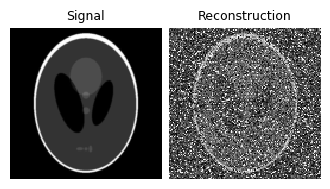

Cosine similarity: 0.5672


In [56]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# Try QR decomposition

In [ ]:
A = torch.randn((5,3),dtype=torch.cfloat,device=device)
print(A)

tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [ ]:
Q, R = torch.linalg.qr(A)
print(Q.shape)
print(R.shape)
print(Q@R)

torch.Size([5, 3])
torch.Size([3, 3])
tensor([[-0.8743+0.3645j, -0.7821-0.3355j,  0.4701-0.8829j],
        [ 0.4294-1.0614j, -0.3441+0.9698j,  0.0404+1.7377j],
        [-0.2848+0.1911j, -0.6175-0.1912j,  0.0704+0.0362j],
        [-1.1079-0.6402j,  0.1408+0.3108j, -1.6640-0.0430j],
        [ 0.2608+0.4154j,  0.3932+1.1281j,  0.0477+0.4164j]], device='cuda:0')


In [ ]:
Q@R-A

tensor([[-1.7881e-07+0.0000e+00j,  0.0000e+00+2.9802e-08j,
          1.1921e-07-3.5763e-07j],
        [ 2.9802e-08+0.0000e+00j, -5.9605e-08+5.9605e-08j,
          1.0803e-07-1.1921e-07j],
        [ 0.0000e+00-1.4901e-08j,  0.0000e+00+1.4901e-08j,
          2.9802e-08-5.5879e-08j],
        [-1.1921e-07-5.9605e-08j,  1.4901e-08-2.9802e-08j,
          0.0000e+00-8.5682e-08j],
        [ 0.0000e+00+0.0000e+00j,  5.9605e-08+1.1921e-07j,
         -1.1921e-07-2.9802e-08j]], device='cuda:0')

In [ ]:
print(torch.diag(R))
print(torch.sgn(torch.diag(R)))
print(torch.diag(torch.sgn(torch.diag(R))))

tensor([ 2.0503+0.j,  1.9024+0.j, -2.4322+0.j], device='cuda:0')
tensor([ 1.+0.j,  1.+0.j, -1.+0.j], device='cuda:0')
tensor([[ 1.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j,  0.+0.j, -1.+0.j]], device='cuda:0')


In [ ]:
B = torch.arange(1,10).reshape(3,3).to(device).to(torch.cfloat)
print(B)
print(B*torch.sgn(torch.diag(R))[None,:])

tensor([[1.+0.j, 2.+0.j, 3.+0.j],
        [4.+0.j, 5.+0.j, 6.+0.j],
        [7.+0.j, 8.+0.j, 9.+0.j]], device='cuda:0')
tensor([[ 1.+0.j,  2.+0.j, -3.+0.j],
        [ 4.+0.j,  5.+0.j, -6.+0.j],
        [ 7.+0.j,  8.+0.j, -9.+0.j]], device='cuda:0')


# Try Haar matrix

In [ ]:
# Set up the variable to fetch dataset and operators.
img_size = 99
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j * x * torch.pi - 0.5j * torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [ ]:
physics = dinv.physics.RandomPhaseRetrieval(
    m=3*torch.prod(torch.tensor(x.shape)),
    img_shape=(1, img_size, img_size),
    dtype=torch.cfloat,
    device=device,
    use_haar=True,
)

y = physics(x_phase)

Using Haar matrix


In [ ]:
assert torch.allclose((physics.B.A_adjoint(physics.B(x_phase))),x_phase)

In [ ]:
data_fidelity = L2()
#prior = dinv.optim.prior.PnP(denoiser=denoiser_complex)
prior = dinv.optim.prior.Zero()
max_iter = 10000
early_stop = True
verbose = True
# stepsize: use 1e-4 for oversampling ratio 0-2, and 3e-3*oversampling for oversampling ratio 2-9
step_size = 1e-2

In [ ]:
def spectral_methods_wrapper(y, physics, n_iter=5000, **kwargs):
    x = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    z = spectral_methods(y, physics, n_iter=n_iter, **kwargs)
    return {"est": (x, z)}

In [ ]:
params_algo = {"stepsize": step_size, "g_param": 0.00}
print("stepsize:", params_algo["stepsize"])
model = optim_builder(
    iteration="PGD",
    prior=prior,
    data_fidelity=data_fidelity,
    early_stop=early_stop,
    max_iter=max_iter,
    verbose=verbose,
    params_algo=params_algo,
    custom_init=spectral_methods_wrapper,
)

x_phase_gd_spec = model(y, physics, x_gt=x_phase)

stepsize: 0.01


Image 0, channel 0 does not have a global phase shift.


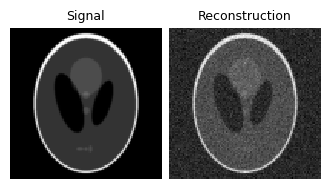

Cosine similarity: 0.9745


In [ ]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# now no global phase shift should exist
#assert torch.allclose(x_est, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / (2*torch.pi) + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')
print(f"Cosine similarity: {cosine_similarity(x_phase_gd_spec, x_phase):.4f}")

# 1 layer drop tail or not 

In [89]:
# create model and generate measurements

physics = dinv.physics.StructuredRandomPhaseRetrieval(
            n_layers=1,
            input_shape=(1, img_size, img_size),
            output_shape=(1, 173, 173),
            shared_weights=True,
            drop_tail=True,
            dtype = torch.cfloat,
            device=device,
        )

y = physics(x_phase)

In [90]:
x_hat = spectral_methods(y, physics, n_iter=5000)

cosine_similarity(x_hat, x_phase)

tensor(0.0486, device='cuda:0')

# any size of images

torch.Size([1, 1, 5, 3])


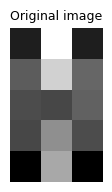

In [90]:
# Load image
img_size = 4
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=(5,3), grayscale=True, resize_mode="resize", device=device
)
print(x.shape)
plot(x, titles="Original image")

# generate phase signal

# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi).to(device)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [94]:
input_shape = torch.tensor((1, 5, 3))
output_shape = torch.tensor((1, 6, 3))

change_top = math.ceil(abs(input_shape[1] - output_shape[1])/2)
change_bottom = math.floor(abs(input_shape[1] - output_shape[1])/2)
change_left = math.ceil(abs(input_shape[2] - output_shape[2])/2)
change_right = math.floor(abs(input_shape[2] - output_shape[2])/2)

print(change_left,change_right,change_top,change_bottom)

assert change_left + change_right == abs(input_shape[2] - output_shape[2])
assert change_top + change_bottom == abs(input_shape[1] - output_shape[1])

0 0 1 0


In [95]:
padding = torch.nn.ZeroPad2d((change_left,change_right,change_top,change_bottom))

def trimming(tensor: torch.Tensor):
    if change_bottom == 0:
        tensor = tensor[...,change_top:,:]
    else:
        tensor = tensor[...,change_top:-change_bottom,:]
    if change_right == 0:
        tensor = tensor[...,change_left:]
    else:
        tensor = tensor[...,change_left:-change_right]
    return tensor

In [97]:
x_phase_new = padding(x_phase)
x_phase_new = torch.fft.fft2(x_phase_new, norm='ortho')
x_phase_new = torch.fft.ifft2(x_phase_new, norm='ortho')
x_phase_new = trimming(x_phase_new)

#assert torch.allclose(x_phase_new, x_phase)

print(x_phase_new)
print(x_phase)

tensor([[[[0.2677-0.9635j, 0.7264-0.6872j, 0.2677-0.9635j],
          [0.4067-0.9135j, 0.6459-0.7634j, 0.4291-0.9032j],
          [0.3727-0.9280j, 0.3612-0.9325j, 0.4180-0.9085j],
          [0.3612-0.9325j, 0.5159-0.8566j, 0.3727-0.9280j],
          [0.1958-0.9806j, 0.5677-0.8233j, 0.1958-0.9806j]]]], device='cuda:0')
tensor([[[[0.2677-0.9635j, 0.7264-0.6872j, 0.2677-0.9635j],
          [0.4067-0.9135j, 0.6459-0.7634j, 0.4291-0.9032j],
          [0.3727-0.9280j, 0.3612-0.9325j, 0.4180-0.9085j],
          [0.3612-0.9325j, 0.5159-0.8566j, 0.3727-0.9280j],
          [0.1958-0.9806j, 0.5677-0.8233j, 0.1958-0.9806j]]]], device='cuda:0')


In [89]:
x_random = torch.randn(1, 1, 4, 4).to(device)
print(x_random)
x_random = padding(x_random)
x_random = trimming(x_random)
print(x_random)

tensor([[[[-0.5748, -1.2221,  1.4677,  0.3021],
          [-0.2890, -1.3209, -1.8855,  2.5176],
          [-3.0000, -0.3725, -0.6453, -1.5584],
          [-0.8070, -1.6998, -1.0418,  0.0125]]]], device='cuda:0')
tensor([[[[-0.5748, -1.2221,  1.4677,  0.3021],
          [-0.2890, -1.3209, -1.8855,  2.5176],
          [-3.0000, -0.3725, -0.6453, -1.5584],
          [-0.8070, -1.6998, -1.0418,  0.0125]]]], device='cuda:0')
